# Imports

In [1]:
## Setting up API key and environment related imports

import os
import re
import sys
import openai
import getpass
import random
from dotenv import load_dotenv,find_dotenv
_ = load_dotenv(find_dotenv())

In [2]:
import uuid
from PIL import Image
from IPython.display import display,HTML, Image as IPythonImage

In [3]:
PLOT_DIR = "plots"
os.makedirs(PLOT_DIR, exist_ok=True)

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
## LangGraph related imports

from langgraph.graph import StateGraph,END
from typing import TypedDict, Annotated
import operator

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [7]:
import functools
from typing import TypedDict, Annotated

In [8]:
## LangChain related imports

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage,ToolMessage, AIMessage
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.schema import HumanMessage
from langchain_core.tools import tool
from langchain_experimental.agents import create_pandas_dataframe_agent

In [9]:
## Model/LLM related imports
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o",api_key = openai.api_key,temperature=0)

-----
<h1 style="text-align: center;">Multi- Agent Workflow</h1>

<p style="text-align: center;">
  <img src="SupervisorAgenticFlow_II.png" />
</p>


## Defining various components

### >> <span style="background-color: yellow; color: black;">Supervisor</span>:

```
Supervisor is responsible for managing the conversation flow between multiple agents, ensuring that 
each agent performs their assigned tasks in the correct order based on the user's query. The Supervisor analyzes the conversation history, decides which agent should act next, and routes the conversation accordingly. If no further action is needed, the Supervisor routes the process to FINISH. The Supervisor ensures smooth coordination and task completion by assigning specific roles to agents like the BI Agent, Driver Identification Agent, Cost Saving Agent, and Generate Scenario Agent. 
```

----

#### >>> <span style="background-color: cyan; color: black;">BI Agent</span>:
- **Role:**
```
BI Agent (Business Intelligence Agent) is responsible for analyzing shipment data to generate insights. 
It handles tasks such as performing exploratory data analysis (EDA), calculating summary statistics, 
identifying trends, comparing metrics across different dimensions (e.g., users, regions), and generating 
visualizations to help understand shipment-related patterns and performance.
```

- **Toolkit:**
    - {***tool_name***: PythonASTRepl(), ***description*** : to generate and execute code}
    
    
- **Example Question:**
- **Example Response:**
    
----

#### >>> <span style="background-color: cyan; color: black;">Driver Identification Agent</span>:
```
WIP..
```
----

#### >>> <span style="background-color: cyan; color: black;">Cost Optimzation Agent</span>:
- **Role:**
```
Cost Optimization Agent is responsible for analyzing shipment cost-related data and recommending 
strategies to reduce or optimize costs. This agent handles tasks such as identifying cost-saving opportunities, calculating the optimal number of trips, performing scenario-based cost optimizations (e.g., varying consolidation windows, truck capacity adjustments), and providing benchmarks and comparisons between current and optimized operations. The agent also calculates key performance metrics like cost per pallet, truck utilization rate, and cost savings over time. This agent is called when the user asks about shipment cost reduction or optimization scenarios.
```
- **Toolkit:**
    - {***tool_name***: PythonASTRepl(), ***description*** : to generate and execute code}
    
    
- **Example Question:**
- **Example Response:**

----

#### >>> <span style="background-color: cyan; color: black;">Generate Scenario Agent</span>:
- **Role:**
```
Generate Scenario Agent is responsible for creating and analyzing "what-if" scenarios 
based on user-defined parameters. This agent helps compare the outcomes of various decisions 
or actions, such as the impact of increasing truck capacity, changing shipment consolidation strategies, 
or exploring different operational scenarios. It can model changes in the system and assess the 
consequences of those changes to support decision-making and optimization. This agent is called when the user asks about scenario generation, comparisons of different outcomes, or analysis of hypothetical situations.
```

- **Toolkit:**
    - {***tool_name***: PythonASTRepl(), ***description*** : to generate and execute code}
    
    
- **Example Question:**
- **Example Response:**



---
## Creating a Supervisor

In [10]:
role = """
You are a Multi-Agent Supervisor and you are responsible for managing the conversation flow between multiple 
agents, ensuring that each agent performs their assigned tasks in the correct order based on the user's query. 
The Supervisor analyzes the conversation history, decides which agent should act next, and routes the conversation accordingly.
The Supervisor ensures smooth coordination and task completion by assigning specific roles to agents 
like the "BI Agent", "Cost Saving Agent", and "Generate Scenario Agent".

If no further action is needed or there is no need to call an agent, the Supervisor routes the process to "FINISH".

If the Supervisor is uncertain about the user's intent or if the question does not fit any specific agent, 
it should route the query to the "FINISH".

"""

In [11]:
# Define the members
members = [
    {
        "agent_name": "BI Agent", 
        "description": 
        """BI Agent (Business Intelligence Agent) is responsible for analyzing shipment data to generate insights. 
         It handles tasks such as performing exploratory data analysis (EDA), calculating summary statistics, 
         identifying trends, comparing metrics across different dimensions (e.g., users, regions), and generating 
         visualizations to help understand shipment-related patterns and performance."""},
    {
        "agent_name": "Cost Saving Agent", 
        "description": 
        """Cost Optimization Agent is responsible for analyzing shipment cost-related data and recommending 
        strategies to reduce or optimize costs. This agent handles tasks such as identifying cost-saving 
        opportunities, calculating the optimal number of trips, performing scenario-based cost optimizations 
        (e.g., varying consolidation windows, truck capacity adjustments), and providing benchmarks and 
        comparisons between current and optimized operations. The agent also calculates key performance 
        metrics like cost per pallet, truck utilization rate, and cost savings over time. This agent is 
        called when the user asks about shipment cost reduction or optimization scenarios."""},
    {
        "agent_name": "Generate Scenario Agent", 
        "description": 
        """Generate Scenario Agent is responsible for creating and analyzing "what-if" scenarios based on 
        user-defined parameters. This agent helps compare the outcomes of various decisions or actions, such 
        as the impact of increasing truck capacity, changing shipment consolidation strategies, or exploring 
        different operational scenarios. It can model changes in the system and assess the consequences of 
        those changes to support decision-making and optimization. This agent is called when the user asks 
        about scenario generation, comparisons of different outcomes, or analysis of hypothetical situations."""},
    
]


In [12]:
# Define the options for workers
options = ["FINISH"] + [mem['agent_name'] for mem in members]

# Generate members information for the prompt
members_info = "\n\n".join([f"{member['agent_name']}: {re.sub(r'\s+', ' ', member['description'].replace('\n',' ')).strip()}" for member in members])

# print(members_info)

In [13]:
final_prompt = role + "\nHere is the information about the different agents you've:\n\n"+members_info
final_prompt = final_prompt + f"\n\nUse tha above information while answering to the question asked by the user; You should reply with who should act next? Or should we FINISH? Select one of:\n{options}"
print(final_prompt)


You are a Multi-Agent Supervisor and you are responsible for managing the conversation flow between multiple 
agents, ensuring that each agent performs their assigned tasks in the correct order based on the user's query. 
The Supervisor analyzes the conversation history, decides which agent should act next, and routes the conversation accordingly.
The Supervisor ensures smooth coordination and task completion by assigning specific roles to agents 
like the "BI Agent", "Cost Saving Agent", and "Generate Scenario Agent".

If no further action is needed or there is no need to call an agent, the Supervisor routes the process to "FINISH".

If the Supervisor is uncertain about the user's intent or if the question does not fit any specific agent, 
it should route the query to the "FINISH".


Here is the information about the different agents you've:

BI Agent: BI Agent (Business Intelligence Agent) is responsible for analyzing shipment data to generate insights. It handles tasks such as perf

In [14]:
# Define the prompt with placeholders for variables
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", final_prompt.strip()),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [15]:
# Define the function schema for routing
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}

In [16]:
supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)


/var/folders/0h/w2x5g9nd77x9s1fk2h7qj9980000gp/T/ipykernel_76931/1653979275.py:3: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


In [17]:
supervisor_chain.invoke([HumanMessage(content="Summary about my data.")])

{'next': 'BI Agent'}

In [18]:
supervisor_chain.invoke([HumanMessage(content="How can I optimise my shipment cost?")])

{'next': 'Cost Saving Agent'}

In [19]:
supervisor_chain.invoke([HumanMessage(content="Compare shipment saving if I were to reduce truck capacity by 30%.")])

{'next': 'Generate Scenario Agent'}

In [20]:
supervisor_chain.invoke([HumanMessage(content="These are the results we got from the agent. `..ans..`")])

{'next': 'FINISH'}

----
## Creating a BI Agent

### Defining Helper Functions

In [21]:
def get_prompt_file(data_source):
    """Return the appropriate prompt file based on the data source."""
    prompt_mapping = {
        'Outbound_Data.csv': 'Prompts/Prompt1.txt',
        'Inventory_Batch.csv': 'Prompts/Prompt2.txt',
        'Inbound_Data.csv': 'Prompts/Prompt3.txt'
    }
    return prompt_mapping.get(data_source)

In [22]:
def extract_code_segments(response_text):
    """Extract code segments from the API response using regex."""
    segments = {}
    
    # Extract approach section
    approach_match = re.search(r'<approach>(.*?)</approach>', response_text, re.DOTALL)
    if approach_match:
        segments['approach'] = approach_match.group(1).strip()
    
    # Extract content between <code> tags
    code_match = re.search(r'<code>(.*?)</code>', response_text, re.DOTALL)
    if code_match:
        segments['code'] = code_match.group(1).strip()
    
    # Extract content between <chart> tags
    chart_match = re.search(r'<chart>(.*?)</chart>', response_text, re.DOTALL)
    if chart_match:
        segments['chart'] = chart_match.group(1).strip()
    
    # Extract content between <answer> tags
    answer_match = re.search(r'<answer>(.*?)</answer>', response_text, re.DOTALL)
    if answer_match:
        segments['answer'] = answer_match.group(1).strip()
    
    return segments

In [23]:
def display_saved_plot(plot_path: str) -> None:
    """
    Loads and displays a saved plot from the given path using IPython display to prevent non-interactive warnings.

    Args:
        plot_path (str): Path to the saved plot image.
    """
    if os.path.exists(plot_path):
        display(IPythonImage(filename=plot_path))
    else:
        print(f"Plot not found at {plot_path}")

In [24]:
@tool
def execute_analysis(df, response_text):
    """Execute the extracted code segments on the provided dataframe and store formatted answer."""
    results = {
        'approach': None,
        'answer': None,
        'figure': None,
        'code': None,
        'chart_code': None
    }
    
    try:
        # Extract code segments
        segments = extract_code_segments(response_text)
        
        if not segments:
            print("No code segments found in the response")
            return results
        
        # Store the approach and raw code
        if 'approach' in segments:
            results['approach'] = segments['approach']
        if 'code' in segments:
            results['code'] = segments['code']
        if 'chart' in segments:
            results['chart_code'] = segments['chart']
        
        # Create a single namespace for all executions
        namespace = {'df': df, 'pd': pd, 'plt': plt, 'sns': sns}
        
        # Execute analysis code and answer template
        if 'code' in segments and 'answer' in segments:
            # Properly dedent the code before execution
            code_lines = segments['code'].strip().split('\n')
            # Find minimum indentation
            min_indent = float('inf')
            for line in code_lines:
                if line.strip():  # Skip empty lines
                    indent = len(line) - len(line.lstrip())
                    min_indent = min(min_indent, indent)
            # Remove consistent indentation
            dedented_code = '\n'.join(line[min_indent:] if line.strip() else '' 
                                    for line in code_lines)
            
            # Combine code with answer template
            combined_code = f"""
{dedented_code}

# Format the answer template
answer_text = f'''{segments['answer']}'''
"""
            exec(combined_code, namespace)
            results['answer'] = namespace.get('answer_text')
        
        # Execute chart code if present
#         if 'chart' in segments:
#             # Properly dedent the chart code
#             chart_lines = segments['chart'].strip().split('\n')
#             # Find minimum indentation
#             min_indent = float('inf')
#             for line in chart_lines:
#                 if line.strip():  # Skip empty lines
#                     indent = len(line) - len(line.lstrip())
#                     min_indent = min(min_indent, indent)
#             # Remove consistent indentation
#             dedented_chart = '\n'.join(line[min_indent:] if line.strip() else '' 
#                                      for line in chart_lines)
            
#             print("Chart Code:\n",dedented_chart)
#             plt.figure(figsize=(10, 6))
#             exec(dedented_chart, namespace)
#             fig = plt.gcf()
#             results['figure'] = fig
#             plt.close()

        if 'chart' in segments:
            # Properly dedent the chart code
            if "No" in segments['chart']:
                pass
            else:
                chart_lines = segments['chart'].strip().split('\n')
                chart_lines = [x for x in chart_lines if 'plt.show' not in x]
                # Find minimum indentation
                min_indent = float('inf')
                for line in chart_lines:
                    if line.strip():  # Skip empty lines
                        indent = len(line) - len(line.lstrip())
                        min_indent = min(min_indent, indent)
                # Remove consistent indentation
                dedented_chart = '\n'.join(line[min_indent:] if line.strip() else '' 
                                         for line in chart_lines)

                plot_path = os.path.join(PLOT_DIR, f"plot_{uuid.uuid4().hex}.png")

                # Append savefig logic to the dedented chart code to ensure the figure is saved
                dedented_chart += f"\nplt.savefig('{plot_path}', bbox_inches='tight')"

    #             print("Chart Code:\n",dedented_chart)
    #             plt.figure(figsize=(10, 6))
                exec(dedented_chart, namespace)
    #             fig = plt.gcf()
                results['figure'] = plot_path
    #             plt.close()


        
        return results
        
    except Exception as e:
        print(f"Error during execution: {str(e)}")
        return results
    


### Defining Agent Class

In [25]:
class Agent:
    def __init__(self,llm, prompt, tools, data_description, dataset, helper_functions=None):
        """
        Initialize an Agent with the required properties.

        Parameters:
        - prompt (str): The prompt that defines the agent's task or behavior.
        - tools (list): The tools that the agent has access to (e.g., APIs, functions, etc.)
        - data_description (str): A description of the dataset the agent will work with.
        - dataset (dict or pd.DataFrame): The dataset that the agent will use.
        - helper_functions (dict, optional): A dictionary of helper functions specific to the agent.
        """
        self.llm = llm
        self.prompt = prompt
        self.tools = tools
        self.data_description = data_description
        self.dataset = dataset
        self.helper_functions = helper_functions or {}

    def add_helper_function(self, name, func):
        """
        Add a helper function specific to this agent.

        Parameters:
        - name (str): The name of the function.
        - func (function): The function to be added.
        """
        self.helper_functions[name] = func

    def run(self, question):
        """
        Run the agent's task using the provided question, available tools, and helper functions.

        Parameters:
        - question (str): The question the agent needs to answer or solve.

        Returns:
        - str: The result of the agent's task.
        """
        
        # Define the prompt with placeholders for variables
        prompt_temp = ChatPromptTemplate.from_messages(
            [
                ("system", self.prompt.strip()),
                MessagesPlaceholder(variable_name="messages"),
            ]
        )

        
        # Use the prompt to formulate the response
        result = llm.invoke(prompt_temp.invoke({"data_description":self.data_description,
                            "question":question,
                            "messages":[HumanMessage(content=question)]}))

        return result

    def generate_response(self, question):
        """
        Generate a response using the agent's prompt and data description.

        Parameters:
        - question (str): The question to be answered.

        Returns:
        - str: The generated response based on the prompt and dataset.
        """
        result = self.run(question)
        response = self.helper_functions['execute_analysis'].invoke({"df":self.dataset,"response_text":result.content})
#         message = response['approach']+"\nSolution we got from this approach is:\n"+response['answer']
#         answer = response['answer']
        return response




    def __repr__(self):
        """
        String representation of the agent, showing essential properties.
        """
        return f"Agent(prompt={self.prompt}, tools={self.tools}, data_description={self.data_description}, dataset={self.dataset.head()})"


### Defning variables for Agents

- **Loading dataset and information about dataset**

In [26]:
file_path = '/Users/ay/Desktop/GenAI-POC/Perrigo/Perrigo-GenAI-Answer-Bot'

# Loading dataset
data_source = 'Data/Outbound_Data.csv'
data_source = os.path.join(file_path,data_source)
df = pd.read_csv(data_source)

In [27]:
# Loading data description prompt
prompt_file_path= os.path.join(file_path,get_prompt_file(data_source.split('/')[-1]))
with open(prompt_file_path, 'r') as file:
    data_description = file.read().strip()

- **Writing prompt to define role and give context about the task**

In [28]:
prompt = """
                        
You are an AI assistant tasked with analyzing a dataset to provide code for calculating the final answer and generating relevant visualization.
I will provide you with the data in dataframe format, as well as a question to answer based on the data.

{data_description}

Here is the question I would like you to answer using this data:
<question>
{question}
</question>

To answer this, first think through your approach inside <approach> tags. Break down the steps you
will need to take and consider which columns of the data will be most relevant. Here is an example:
<approach>
To answer this question, I will need to:
1. Calculate the total number of orders and pallets across all rows
2. Determine the average distance and cost per order
3. Identify the most common PROD_TYPE and SHORT_POSTCODE
</approach>

Then, write the Python code needed to analyze the data and calculate the final answer inside <code> tags. Assume input dataframe as 'df'
Be sure to include any necessary data manipulation, aggregations, filtering, etc. Return only the Python code without any explanation or markdown formatting.
For decimal answers round them to 1 decimal place.

Generate Python code using matplotlib and/or seaborn to create an appropriate chart to visualize the relevant data and support your answer.
For example if user is asking for postcode with highest cost then a relevant chart can be a bar chart showing top 10 postcodes with highest total cost arranged in decreasing order.
Specify the chart code inside <chart> tags.
When working with dates:

Always convert dates to datetime using pd.to_datetime() with explicit format
For grouping by month, use dt.strftime('%Y-%m') instead of dt.to_period()
Sort date-based results chronologically before plotting

The visualization code should follow these guidelines:

Start with these required imports:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Use standard chart setup:
# Set figure size and style
plt.figure(figsize=(8, 5))
# Set seaborn default style and color palette
sns.set_theme(style="whitegrid")  
sns.set_palette('pastel')

For time-based charts:


Use string dates on x-axis (converted using strftime)
Rotate labels: plt.xticks(rotation=45, ha='right')
Add gridlines: plt.grid(True, alpha=0.3)

For large numbers:
Format y-axis with K/M suffixes using:

Always include:

Clear title (plt.title())
Axis labels (plt.xlabel(), plt.ylabel())
plt.tight_layout() at the end


For specific chart types:

Time series: sns.lineplot() with marker='o'
Rankings: sns.barplot() with descending sort
Comparisons: sns.barplot() or sns.boxplot()
Distributions: sns.histplot() or sns.kdeplot()

Return only the Python code without any explanation or markdown formatting.

Finally, provide the answer to the question in natural language inside <answer> tags. Be sure to
include any key variables that you calculated in the code inside {{}}."""

- **Adding helper functions**

In [29]:
helper_functions = {"execute_analysis":execute_analysis}

### Calling an Agent

In [30]:
BIAgent = Agent(llm=llm, prompt=prompt, tools=[], data_description=data_description, dataset=df, 
                helper_functions=helper_functions)

In [31]:
X = BIAgent.run(question="What's the average distance of shipment for top 5 largest customers?")
print(X.content)

<approach>
To answer this question, I will need to:
1. Group the data by 'Customer' and calculate the total 'Total_Orders' for each customer.
2. Identify the top 5 customers with the largest total orders.
3. Calculate the average 'Distance' for shipments for these top 5 customers.
4. Return the average distance for these top 5 customers.
</approach>

<code>
import pandas as pd

# Group by 'Customer' and calculate total orders
customer_orders = df.groupby('Customer')['Total_Orders'].sum().reset_index()

# Identify top 5 customers with the largest total orders
top_customers = customer_orders.nlargest(5, 'Total_Orders')

# Filter the original dataframe for these top 5 customers
top_customers_data = df[df['Customer'].isin(top_customers['Customer'])]

# Calculate the average distance for these top 5 customers
average_distance = top_customers_data['Distance'].mean()

average_distance = round(average_distance, 1)
average_distance
</code>

<chart>
import pandas as pd
import matplotlib.pyplot a

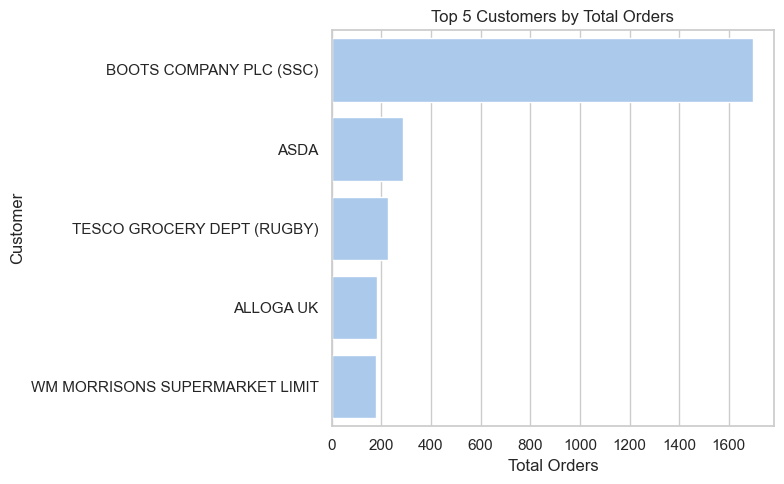

In [32]:
response = BIAgent.generate_response(question="What's the average distance of shipment for top 5 largest customers?")

In [33]:
print(response['answer'])

The average distance of shipment for the top 5 largest customers is 66.5 miles.


In [34]:
# display_saved_plot(response['figure'])

---------
## Creating a Cost Optimization Agent

In [35]:
from cost_optimization import (
 get_parameters_values, consolidate_shipments, calculate_metrics,
    analyze_consolidation_distribution, get_filtered_data
)

In [36]:
from typing import Dict, Any

In [37]:
PLOT_DIR = "plots"
os.makedirs(PLOT_DIR, exist_ok=True)

def execute_plot_code(plot_code: str,df) -> list:
    """
    Executes the provided plotting code. It searches for every occurrence of plt.show() in the code and
    replaces it with a plt.savefig() call that saves the current figure to a unique file.
    If no plt.show() is present and no plt.savefig() exists, it appends a plt.savefig() call at the end.
    
    Args:
        plot_code (str): The code to generate one or more plots.
    
    Returns:
        list: A list of file paths where the plots were saved.
    """
    plot_paths = []
    
    # Function to replace each plt.show() with a unique plt.savefig() call
    def replace_show(match):
        new_path = os.path.join(PLOT_DIR, f"plot_{uuid.uuid4().hex}.png")
        plot_paths.append(new_path)
        # Ensure proper indentation is preserved (using the match group 1)
        indent = match.group(1) if match.lastindex and match.group(1) else ""
        return f"{indent}plt.savefig('{new_path}', bbox_inches='tight')"
    
    # Replace all occurrences of plt.show() with unique plt.savefig() calls
    sanitized_code = re.sub(r'(^\s*)plt\.show\(\)', replace_show, plot_code, flags=re.MULTILINE)
    
    # If no plt.show was found and no plt.savefig exists in the code, append one at the end
    if not re.search(r"plt\.savefig", sanitized_code):
        new_path = os.path.join(PLOT_DIR, f"plot_{uuid.uuid4().hex}.png")
        sanitized_code += f"\nplt.savefig('{new_path}', bbox_inches='tight')"
        plot_paths.append(new_path)
    
#     print("Sanitized Code:\n", sanitized_code)
    
    exec_globals = {"df": df, "sns": sns, "plt": plt}
    try:
        exec(sanitized_code, exec_globals)
        plt.close('all')
    except Exception as e:
        return [f"Error generating plot: {e}"]
    
    return plot_paths

def display_saved_plot(plot_path: str) -> None:
    """
    Loads and displays a saved plot from the given path using IPython display.
    
    Args:
        plot_path (str): Path to the saved plot image.
    """
    if os.path.exists(plot_path):
        display(IPythonImage(filename=plot_path))
    else:
        print(f"Plot not found at {plot_path}")

def extract_plot_code(intermediate_steps: list) -> tuple:
    """
    Extracts the plotting code from the agent's intermediate steps.
    
    Args:
        intermediate_steps (list): Intermediate steps from the agent response.
    
    Returns:
        tuple: (plot_code, response, thought)
    """
    for step in intermediate_steps:
        artifacts, _ = step
        
        # The agent's intermediate steps may contain the code under a key like 'tool_input'
        tool_input_ = artifacts.tool_input
        agent_message = artifacts.log
        
        # Extract plot code (everything after "```python" and before "```")
        match = re.search(r"```python(.*?)```", tool_input_, re.DOTALL)
        plot_code = match.group(1).strip() if match else None
        
        # Extract message (everything before "Thought:")
        response_match = re.search(r'^(.*?)\s*Thought:', agent_message, re.DOTALL)
        response = response_match.group(1).strip() if response_match else agent_message.strip()
        
        # Extract thought (text between "Thought:" and "Action:")
        thought_match = re.search(r'Thought:\s*(.*?)\s*Action:', agent_message, re.DOTALL)
        thought = thought_match.group(1).strip() if thought_match else ""
        
    return plot_code, response, thought

def agent_wrapper(agent_response: dict,df) -> dict:
    """
    Wraps the agent response to extract, execute, and display plotting code for each intermediate step.
    For each step, any generated plots are saved using unique file names.
    
    The final output is constructed to show:
      - Step 1 message
      - Step 1 plot paths
      - Step 2 message
      - Step 2 plot paths
      - ...
      - Final agent response
    
    Args:
        agent_response (dict): Response from the agent.
    
    Returns:
        dict: Contains the agent input, a list of step outputs (each with a message and plot paths),
              and a final_answer string combining all.
    """
    intermediate_steps = agent_response.get("intermediate_steps", [])
    step_outputs = []
    
    for step in intermediate_steps:
        artifacts, _ = step
        tool_input_ = artifacts.tool_input
        agent_log = artifacts.log
        
        # Extract the plotting code from the tool_input
        match = re.search(r"```python(.*?)```", tool_input_, re.DOTALL)
        plot_code = match.group(1).strip() if match else None
        plot_code = plot_code if "plt.show" in plot_code else None
        
        # Extract the message (everything before "Thought:") and optional thought
        message_match = re.search(r'^(.*?)\s*Thought:', agent_log, re.DOTALL)
        message = message_match.group(1).strip() if message_match else agent_log.strip()
        thought_match = re.search(r'Thought:\s*(.*?)\s*Action:', agent_log, re.DOTALL)
        thought = thought_match.group(1).strip() if thought_match else ""
        full_message = message + ("\n" + thought if thought else "")
        
        # Execute the plotting code and get a list of plot paths
        plot_paths = execute_plot_code(plot_code,df) if plot_code else []
        
        step_outputs.append({
            "message": full_message,
            "plot_paths": plot_paths
        })
    
    # Build the final answer by interleaving messages and the list of plot paths
    final_message = ""
    for idx, step in enumerate(step_outputs, 1):
        final_message += f"Step {idx} Message:\n{step['message']}\n"
        if step['plot_paths']:
            for i, path in enumerate(step['plot_paths'], 1):
                final_message += f"Step {idx} Plot {i}: {path}\n"
        else:
            final_message += f"Step {idx} Plot: No plot generated.\n"
    
    final_agent_response = agent_response.get("output", "")
#     final_message += "\nFinal Agent Response:\n" + final_agent_response
    
    return {
        "input": agent_response.get("input"),
        "steps": step_outputs,
        "final_answer": final_agent_response
    }


In [38]:
class AgenticCostOptimizer:
    def __init__(self, llm, parameters):
        """
        Initialize the Agentic Cost Optimizer.

        :param llm: The LLM model to use for queries.
        :param parameters: Dictionary containing required parameters.
        """
        self.llm = llm
        self.parameters = parameters
        self.df = parameters.get("df", pd.DataFrame())
        self.shipment_window_range = (1, 10)
        self.total_shipment_capacity = 36

    def load_data(self):
        self.rate_card_ambient = pd.read_excel('Complete Input.xlsx', sheet_name='AMBIENT')
        self.rate_card_ambcontrol = pd.read_excel('Complete Input.xlsx', sheet_name='AMBCONTROL')
        return {"rate_card_ambient":self.rate_card_ambient,"rate_card_ambcontrol":self.rate_card_ambcontrol}
    
    def get_filtered_df_from_question(self):
        """Extracts filtered data based on user query parameters."""
        group_field = 'SHORT_POSTCODE' if self.parameters['group_method'] == 'Post Code Level' else 'NAME'
        df = self.parameters['df']
        df['SHIPPED_DATE'] = pd.to_datetime(df['SHIPPED_DATE'], dayfirst=True)
        
        df = get_filtered_data(self.parameters, df)
        if df.empty:
            raise ValueError("No data available for selected parameters. Try again!")
        return df
    
    def get_cost_saving_data(self):
        """Runs cost-saving algorithm and returns result DataFrame."""
        
        df = self.get_filtered_df_from_question()
        print("Shape of original data after filtering:",df.shape)
        
        df['GROUP'] = df['SHORT_POSTCODE' if self.parameters['group_method'] == 'Post Code Level' else 'NAME']
        grouped = df.groupby(['PROD TYPE', 'GROUP'])
        date_range = pd.date_range(start=self.parameters['start_date'], end=self.parameters['end_date'])

        
        all_results = []
        rate_card = self.load_data()
        for shipment_window in range(self.shipment_window_range[0], self.shipment_window_range[1] + 1):
            print(f"Consolidating orders for shipment window: {shipment_window}")
            all_consolidated_shipments = []
            for _, group_df in grouped:
                consolidated_shipments, _ = consolidate_shipments(
                    group_df, 0, 95, shipment_window, date_range, lambda: None, self.total_shipment_capacity,rate_card
                )
                all_consolidated_shipments.extend(consolidated_shipments)
            
            metrics = calculate_metrics(all_consolidated_shipments, df)
            distribution, distribution_percentage = analyze_consolidation_distribution(all_consolidated_shipments, df)
            
            result = {
                'Shipment Window': shipment_window,
                'Total Orders': metrics['Total Orders'],
                'Total Shipments': metrics['Total Shipments'],
                'Total Shipment Cost': round(metrics['Total Shipment Cost'], 1),
                'Total Baseline Cost': round(metrics['Total Baseline Cost'], 1),
                'Cost Savings': metrics['Cost Savings'],
                'Percent Savings': round(metrics['Percent Savings'], 1),
                'Average Utilization': round(metrics['Average Utilization'], 1),
                'CO2 Emission': round(metrics['CO2 Emission'], 1)
            }
            all_results.append(result)
        
        self.parameters['all_results'] = pd.DataFrame(all_results)
    
    def consolidate_for_shipment_window(self):
        """Runs consolidation algorithm based on the selected shipment window."""
        df = self.get_filtered_df_from_question()
        df['GROUP'] = df['SHORT_POSTCODE' if self.parameters['group_method'] == 'Post Code Level' else 'NAME']
        grouped = df.groupby(['PROD TYPE', 'GROUP'])
        date_range = pd.date_range(start=self.parameters['start_date'], end=self.parameters['end_date'])
        
        all_consolidated_shipments = []
        rate_card = self.load_data()
        for _, group_df in grouped:
            consolidated_shipments, _ = consolidate_shipments(
                group_df, 0, 95, self.parameters['window'], date_range, lambda: None, self.total_shipment_capacity,rate_card
            )
            all_consolidated_shipments.extend(consolidated_shipments)
        
        self.parameters['all_consolidated_shipments'] = pd.DataFrame(all_consolidated_shipments)
    
    def compare_before_and_after_consolidation(self):
        """Compares shipments before and after consolidation."""
        consolidated_df = self.parameters['all_consolidated_shipments']
        df = self.get_filtered_df_from_question()
        
        before = {
            "Days": df['SHIPPED_DATE'].nunique(),
            "Pallets Per Day": df['Total Pallets'].sum() / df['SHIPPED_DATE'].nunique(),
            "Pallets per Shipment": df['Total Pallets'].sum() / len(df)
        }
        after = {
            "Days": consolidated_df['Date'].nunique(),
            "Pallets Per Day": consolidated_df['Total Pallets'].sum() / consolidated_df['Date'].nunique(),
            "Pallets per Shipment": consolidated_df['Total Pallets'].sum() / len(consolidated_df)
        }
        
        percentage_change = {
            key: round(((after[key] - before[key]) / before[key]) * 100, 2) for key in before
        }
        
        comparison_df = pd.DataFrame({"Before": before, "After": after, "% Change": percentage_change})
#         print(comparison_df.to_dict())
        return comparison_df
    
    def handle_query(self, question):
            """Handles user queries dynamically, storing conversation history."""
            chat_history = []
            chat_history.append({"Human": question})

            result = get_parameters_values(self.parameters["api_key"], question)
            self.parameters.update(result)
            chat_history.append({"Agent": f"Parameters: {result}"})

            self.get_cost_saving_data()
            display(self.parameters['all_results'])
            max_savings_row = self.parameters['all_results'].loc[self.parameters['all_results']['Cost Savings'].idxmax()].to_dict()
            chat_history.append({"Agent": f"Optimum results: {max_savings_row}"})
            
            agent = create_pandas_dataframe_agent(self.llm, self.parameters['all_results'], verbose=False, 
                                                  allow_dangerous_code=True, handle_parsing_errors=True,
                                                 return_intermediate_steps=True)
            while True:
                display(HTML("""
                    <div style="background-color: yellow; padding: 10px; border-radius: 5px; 
                                font-size: 16px; border: 1px solid black; width: fit-content;">
                        <strong>Ask follow-up question or press Enter to proceed:</strong>
                    </div>
                """))
                user_input = input()
                if not user_input:
                    break
                else:
                    try:
                        response = agent.invoke(user_input)

#                         step = response.get("intermediate_steps")[0] # Since, there is only one step
#                         artifacts,output = step
#                         print("Log:\n",artifacts.log)
                        
                        response_ = agent_wrapper(response,self.parameters['all_results'])
        
                        for i,step in enumerate(response_['steps']):
                            print(f"Step {i+1}")
                            print(step['message'])
                            for plot in step['plot_paths']:
                                display_saved_plot(plot)
                        print(response_["final_answer"])
                                


#                         if response_['plot_path']!='No plotting code found.':
#                             display_saved_plot(response_['plot_path'])
                            
                        chat_history.append({"Human": user_input})
                        chat_history.append({"Agent": response_['final_answer']})
                        
#                         print("Agent Response:", response_['answer'])
                    except Exception as e:
                        print("Error processing follow-up question:",e)
                        print("Try reshaping your question.")
                        chat_history.append({"Human": user_input})
                        chat_history.append({"Agent": e})
                    
            user_window = input("Choose shipment window or press Enter to use default: ")
            self.parameters["window"] = int(user_window) if user_window else self.parameters['all_results']['Cost Savings'].idxmax()


            self.consolidate_for_shipment_window()
            display(self.parameters['all_consolidated_shipments'])

            agent = create_pandas_dataframe_agent(self.llm, self.parameters['all_consolidated_shipments'], verbose=False,
                                                  allow_dangerous_code=True,handle_parsing_errors=True,
                                                 return_intermediate_steps=True)
            while True:
                display(HTML("""
                    <div style="background-color: yellow; padding: 10px; border-radius: 5px; 
                                font-size: 16px; border: 1px solid black; width: fit-content;">
                        <strong>Ask follow-up question or press Enter to proceed:</strong>
                    </div>
                """))
                user_followup = input()
                if not user_followup:
                    break
                else:
                    try:
                        response = agent.invoke(user_followup)                        
                        response_ = agent_wrapper(response,self.parameters['all_consolidated_shipments'])
                        
                        for i,step in enumerate(response_['steps']):
                            print(f"Step {i+1}")
                            print(step['message'])
                            for plot in step['plot_paths']:
                                display_saved_plot(plot)
                        
                        print(response_["final_answer"])
                        
#                         if response_['plot_path']!='No plotting code found.':
#                             display_saved_plot(response_['plot_path'])
                            
                        chat_history.append({"Human": user_followup})
                        chat_history.append({"Agent": response_["final_answer"]})
                        
#                         print("Agent Response:", response_['answer'])
                        
                    except Exception as e:
                        print("Error processing follow-up question:", e)
                        print("Try rephrasing your question.")
                        chat_history.append({"Human": user_followup})
                        chat_history.append({"Agent": e})
            
            self.parameters['comparison'] = self.compare_before_and_after_consolidation()
            chat_history.append({"Agent": f"Before and After Consolidation comparison: {self.parameters['comparison'].to_dict()}"})

            return chat_history
    

In [39]:
file_name = "Complete Input.xlsx"
cost_saving_input_df = pd.read_excel('Complete Input.xlsx', sheet_name='Sheet1')

In [40]:
query = "How can I optimize the shipment costs for user ALLOGA UK in January?"

In [41]:
parameters = {"api_key": openai.api_key, 
              "query": query, 
              "file_name":file_name,
              "df": cost_saving_input_df
             }

In [42]:
cost_saving_input_df

,PROD TYPE,NAME,ORDER_ID,BOXES,PALLETS,SHIPPED_DATE,SHORT_POSTCODE,Total Pallets,POSTCODE,Distance
0,AMBCONTROL,POUNDLAND DC,82262574,0,1,2023-02-01,CM,1,CM19 5BD,227.3
1,AMBIENT,RAYBURN TRADING LTD,82262595,0,4,2023-02-01,M,4,M8 8RA,95.9
2,AMBCONTROL,RAYBURN TRADING LTD,82267376,0,1,2023-02-01,M,1,M8 8RA,95.9
3,AMBCONTROL,ONE STOP STORES LTD (NURSLING),82267916,1,0,2023-02-01,SO,1,SO16 0WB,305.1
4,AMBIENT,BOOTS COMPANY PLC (SSC),82271776,0,2,2023-02-01,NG,2,NG7 2SD,29.8
...,...,...,...,...,...,...,...,...,...,...
17908,AMBCONTROL,ALLOGA UK,82900755,0,10,2024-12-11,NG,10,NG17 1BX,12.2
17909,AMBCONTROL,ALLOGA UK,82900756,0,5,2024-12-11,NG,5,NG17 1BX,12.2
17910,AMBCONTROL,ALLOGA UK,82900777,0,26,2024-12-11,NG,26,NG17 1BX,12.2
17911,AMBCONTROL,SAINSBURY'S SUPERMARKETS LTD (,82916627,0,11,2024-12-11,EN,11,EN11 0EZ,222.9


In [43]:
agent = AgenticCostOptimizer(llm, parameters)
conv = agent.handle_query(query)

{ "start_date": "2024-01-01",
  "end_date": "2024-01-31",
  "group_method": "Customer Level",
  "all_post_code": None,
  "all_customers": False,
  "selected_postcodes": [],
  "selected_customers": ["ALLOGA UK"] }
['ALLOGA UK', 'ALLOGA UK LIMITED', 'ALLOGA UK (FAO CEUTA)', 'ALLOGA UK LTD - AP 3']
[]
Shape of original data after filtering: (41, 10)
Consolidating orders for shipment window: 1
Consolidating orders for shipment window: 2
Consolidating orders for shipment window: 3
Consolidating orders for shipment window: 4
Consolidating orders for shipment window: 5
Consolidating orders for shipment window: 6
Consolidating orders for shipment window: 7
Consolidating orders for shipment window: 8
Consolidating orders for shipment window: 9
Consolidating orders for shipment window: 10


,Shipment Window,Total Orders,Total Shipments,Total Shipment Cost,Total Baseline Cost,Cost Savings,Percent Savings,Average Utilization,CO2 Emission
0,1,41,20,5476.4,6274.7,798.3,12.7,53.2,321.6
1,2,41,19,5323.5,6274.7,951.2,15.2,56.0,346.0
2,3,41,19,5323.5,6274.7,951.2,15.2,56.0,346.0
3,4,41,19,5323.5,6274.7,951.2,15.2,56.0,346.0
4,5,41,19,5209.3,6274.7,1065.4,17.0,56.0,346.0
5,6,41,16,5118.6,6274.7,1156.1,18.4,66.5,398.0
6,7,41,15,5047.7,6274.7,1227.0,19.6,70.9,380.0
7,8,41,14,5023.1,6274.7,1251.6,19.9,76.0,404.4
8,9,41,14,5023.1,6274.7,1251.6,19.9,76.0,404.4
9,10,41,14,4978.9,6274.7,1295.8,20.7,76.0,404.4


 
Choose shipment window or press Enter to use default:  10


,Date,Orders,Total Pallets,Capacity,Utilization %,Order Count,Pallets,PROD TYPE,GROUP,Shipment Cost,Baseline Cost,SHORT_POSTCODE,Load Type
0,2024-01-02,"[82579108, 82595330, 82595334, 82595322, 82617...",36,36,100.0,5,"[17, 3, 3, 2, 11]",AMBCONTROL,ALLOGA UK,427.8,616.5,NG,Full
1,2024-01-02,"[82614233, 82614232]",36,36,100.0,2,"[18, 18]",AMBCONTROL,ALLOGA UK,427.8,567.0,NG,Full
2,2024-01-02,"[82614234, 82595311, 82595318]",35,36,97.2,3,"[18, 15, 2]",AMBCONTROL,ALLOGA UK,427.8,568.7,NG,Full
3,2024-01-10,"[82595325, 82615621, 82624372, 82595324, 82595...",36,36,100.0,5,"[2, 19, 12, 2, 1]",AMBCONTROL,ALLOGA UK,427.8,616.8,NG,Full
4,2024-01-15,"[82595319, 82625446]",27,36,75.0,2,"[5, 22]",AMBCONTROL,ALLOGA UK,427.8,418.6,NG,Full
5,2024-01-18,[82624373],18,36,50.0,1,[18],AMBCONTROL,ALLOGA UK,283.5,283.5,NG,Partial
6,2024-01-22,"[82625436, 82624375, 82628876]",36,36,100.0,3,"[19, 12, 5]",AMBCONTROL,ALLOGA UK,427.8,583.7,NG,Full
7,2024-01-31,[82624374],18,36,50.0,1,[18],AMBCONTROL,ALLOGA UK,283.5,283.5,NG,Partial
8,2024-01-02,"[82595320, 82595329, 82579114, 82601105]",34,36,94.4,4,"[5, 2, 20, 7]",AMBCONTROL,ALLOGA UK LTD - AP 3,424.3,565.0,DE,Full
9,2024-01-02,"[82601107, 82595312, 82595333]",36,36,100.0,3,"[18, 15, 3]",AMBCONTROL,ALLOGA UK LTD - AP 3,424.3,577.5,DE,Full


In [44]:
chat=[]
for msg in conv:
    key, value = list(msg.items())[0]
    if "Agent" in key:
        if type(value) is not str:
            value = str(value)
        chat.append(AIMessage(content=value))
    else:
        chat.append(HumanMessage(content=value))

In [45]:
result = llm.invoke(f"Summarise this conversation and provide a formatted response to the first question asked by human. Hers is the conversation: {chat}")


In [46]:
display(Markdown("**Question**: \n\n"+parameters["query"]+'\n\n'+"**Answer**: \n\n"+result.content))

**Question**: 

How can I optimize the shipment costs for user ALLOGA UK in January?

**Answer**: 

**Summary of the Conversation:**

The human asked how to optimize shipment costs for the user "ALLOGA UK" in January. The AI provided parameters for the analysis, including the date range and customer details. The AI then presented the optimum results, showing a cost savings of 20.7% and a reduction in CO2 emissions. Additionally, a comparison of shipment metrics before and after consolidation was provided, highlighting significant improvements in efficiency.

**Formatted Response to the First Question:**

To optimize the shipment costs for user ALLOGA UK in January, the following parameters were considered:

- **Date Range:** January 1, 2024, to January 31, 2024
- **Group Method:** Customer Level
- **Selected Customers:** 
  - ALLOGA UK
  - ALLOGA UK LIMITED
  - ALLOGA UK (FAO CEUTA)
  - ALLOGA UK LTD - AP 3

The analysis resulted in the following optimum results:

- **Shipment Window:** 10.0 days
- **Total Orders:** 41.0
- **Total Shipments:** 14.0
- **Total Shipment Cost:** £4978.9
- **Total Baseline Cost:** £6274.7
- **Cost Savings:** £1295.8
- **Percent Savings:** 20.7%
- **Average Utilization:** 76.0%
- **CO2 Emission:** 404.4

The comparison of shipment metrics before and after consolidation showed:

- **Days:** Reduced by 37.5%
- **Pallets Per Day:** Increased by 60.0%
- **Pallets per Shipment:** Increased by 192.86%

----
## Building a Workflow using Graph

In [47]:
from langgraph.graph.message import add_messages
from uuid import uuid4

In [48]:
class AgentState(TypedDict):
#     messages: Annotated[list[AnyMessage], operator.add]
    messages : Annotated[list[AnyMessage], add_messages]
    next : str

In [49]:
def supervisor_node(state: AgentState,chain=supervisor_chain):
    result = supervisor_chain.invoke(state['messages'])
    
    return {"messages": [AIMessage(content=f"Calling {result['next']}.")],"next":result['next']}

In [50]:
def agent_node(state, agent, name):
    result = agent(state) # This result will be the list of messages
    return {"messages": result,"next":"supervisor"}

In [51]:
def bi_agent(state: AgentState):
    """BI Agent (Business Intelligence Agent) is responsible for analyzing shipment data to generate insights. 
    It handles tasks such as performing exploratory data analysis (EDA), calculating summary statistics, identifying trends, 
    comparing metrics across different dimensions (e.g., users, regions), and generating visualizations to help 
    understand shipment-related patterns and performance.
    """
    BIAgent = Agent(llm=llm, prompt=prompt, tools=[], data_description=data_description, dataset=df, 
                helper_functions=helper_functions)
    
    question = state['messages'][len(state['messages'])-2].content

    response = BIAgent.generate_response(question)
    
    if response['figure']:
        display_saved_plot(response['figure'])
        
    message = response['approach']+"\nSolution we got from this approach is:\n"+response['answer']
    
    

    return [HumanMessage(content=message)]

In [52]:
def cost_saving_agent(state: AgentState):
    """Cost Optimization Agent is responsible for analyzing shipment cost-related data and recommending 
    strategies to reduce or optimize costs. This agent handles tasks such as identifying cost-saving 
    opportunities, calculating the optimal number of trips, performing scenario-based cost optimizations 
    (e.g., varying consolidation windows, truck capacity adjustments), and providing benchmarks and comparisons
    between current and optimized operations. The agent also calculates key performance metrics like cost per 
    pallet, truck utilization rate, and cost savings over time. This agent is called when the user asks about 
    shipment cost reduction or optimization scenarios."""
    
    file_name = "Complete Input.xlsx"
    cost_saving_input_df = pd.read_excel('Complete Input.xlsx', sheet_name='Sheet1')
    query = state['messages'][len(state['messages'])-2].content
    
    
    parameters = {"api_key": openai.api_key, 
              "query": query, 
              "file_name":file_name,
              "df": cost_saving_input_df
             }
    
    agent = AgenticCostOptimizer(llm, parameters)
    conv = agent.handle_query(query)
    
    chat=[]
    for msg in conv:
        key, value = list(msg.items())[0]
        if "Agent" in key:
            if type(value) is not str:
                value = str(value)
            chat.append(AIMessage(content=value))
        else:
            chat.append(HumanMessage(content=value))
    
    result = llm.invoke(f"Summarise this conversation and provide a formatted response to the first question asked by human. Hers is the conversation: {chat}")
#     AIMessage(content=result.content)
    
    message = result.content
    return [HumanMessage(content=message)]

In [53]:
def generate_scenario_agent(state: AgentState):
    """Generate Scenario Agent is responsible for creating and analyzing "what-if" scenarios based on 
    user-defined parameters. This agent helps compare the outcomes of various decisions or actions, such as 
    the impact of increasing truck capacity, changing shipment consolidation strategies, or exploring different 
    operational scenarios. It can model changes in the system and assess the consequences of those changes to 
    support decision-making and optimization. This agent is called when the user asks about scenario generation,
    comparisons of different outcomes, or analysis of hypothetical situations."""
    
    message = 'Generate Scenario Agent Called..! This is your answer: <x></x>. Choose next as "FINISH"'
    return [HumanMessage(content=message)]

In [54]:
# Defining Agent Nodes..!
bi_agent_node = functools.partial(agent_node, agent=bi_agent, name="BI Agent")
cost_saving_agent_node = functools.partial(agent_node, agent=cost_saving_agent, name="Cost Saving Agent")
generate_scenario_agent_node = functools.partial(agent_node, agent=generate_scenario_agent, name="Generate Scenario Agent")

In [55]:
workflow = StateGraph(AgentState)
workflow.add_node("BI Agent", bi_agent_node)
workflow.add_node("Cost Saving Agent", cost_saving_agent_node)
workflow.add_node("Generate Scenario Agent", generate_scenario_agent_node)
# workflow.add_node("Conversation Agent", conversation_agent_node)
# workflow.add_node("RAG", rag_node)
workflow.add_node("supervisor", supervisor_node)

In [56]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member['agent_name'], "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k['agent_name']: k['agent_name'] for k in members}
# conditional_map["Conversation Agent"] = END
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile(checkpointer=memory)

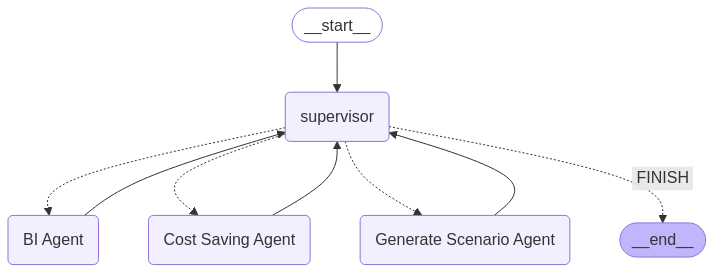

In [57]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

----

In [58]:
graph.nodes

{'__start__': <langgraph.pregel.read.PregelNode at 0x103c924e0>,
 'BI Agent': <langgraph.pregel.read.PregelNode at 0x16b47acf0>,
 'Cost Saving Agent': <langgraph.pregel.read.PregelNode at 0x16b47b790>,
 'Generate Scenario Agent': <langgraph.pregel.read.PregelNode at 0x177251c50>,
 'supervisor': <langgraph.pregel.read.PregelNode at 0x16ae964e0>}

-----

#### Checking the working of BI Agent

In [59]:
state = {"messages":[HumanMessage(content="What's the average distance of shipment for top 5 largest customers?")],"next":"supervisor"}

In [60]:
current_state= graph.nodes['supervisor'].invoke(state)
current_state

{'messages': [AIMessage(content='Calling BI Agent.', additional_kwargs={}, response_metadata={})],
 'next': 'BI Agent'}

In [61]:
state['messages']=add_messages(state['messages'],current_state['messages'])
state['next'] = current_state['next']
state

{'messages': [HumanMessage(content="What's the average distance of shipment for top 5 largest customers?", additional_kwargs={}, response_metadata={}, id='b03612d4-4ab2-45ad-93ed-197acd945b40'),
  AIMessage(content='Calling BI Agent.', additional_kwargs={}, response_metadata={}, id='05fbc7fc-955a-4712-b92e-e3280baa4ced')],
 'next': 'BI Agent'}

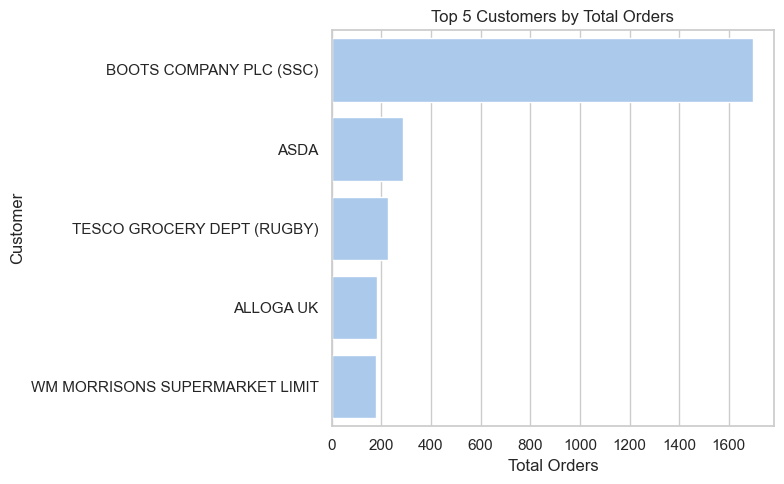

{'messages': [HumanMessage(content="To answer this question, I will need to:\n1. Group the data by 'Customer' and calculate the total 'Total_Orders' for each customer.\n2. Identify the top 5 customers with the largest total orders.\n3. Calculate the average 'Distance' for shipments related to these top 5 customers.\nSolution we got from this approach is:\nThe average distance of shipment for the top 5 largest customers is 66.5 miles.", additional_kwargs={}, response_metadata={})],
 'next': 'supervisor'}

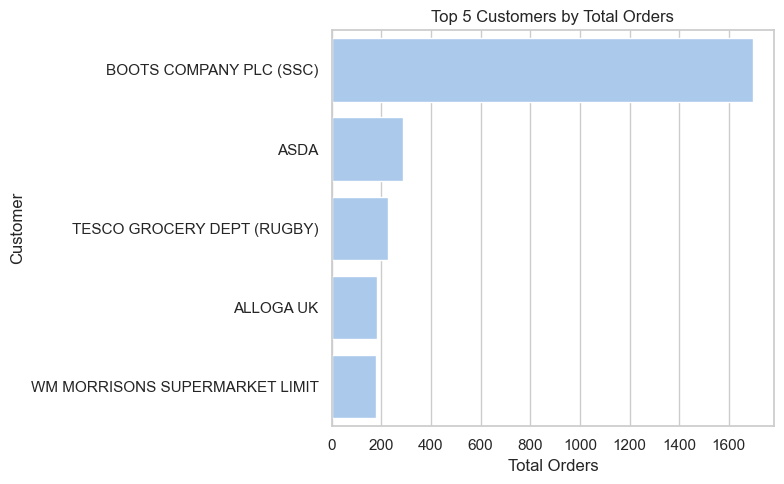

In [62]:
current_state = graph.nodes['BI Agent'].invoke(state)
current_state

In [63]:
state['messages']=add_messages(state['messages'],current_state['messages'])
state['next'] = current_state['next']
state

{'messages': [HumanMessage(content="What's the average distance of shipment for top 5 largest customers?", additional_kwargs={}, response_metadata={}, id='b03612d4-4ab2-45ad-93ed-197acd945b40'),
  AIMessage(content='Calling BI Agent.', additional_kwargs={}, response_metadata={}, id='05fbc7fc-955a-4712-b92e-e3280baa4ced'),
  HumanMessage(content="To answer this question, I will need to:\n1. Group the data by 'Customer' and calculate the total 'Total_Orders' for each customer.\n2. Identify the top 5 customers with the largest total orders.\n3. Calculate the average 'Distance' for shipments related to these top 5 customers.\nSolution we got from this approach is:\nThe average distance of shipment for the top 5 largest customers is 66.5 miles.", additional_kwargs={}, response_metadata={}, id='ed856463-7436-432a-b16e-2003c865d947')],
 'next': 'supervisor'}

In [64]:
current_state = graph.nodes['supervisor'].invoke(state)
current_state

{'messages': [AIMessage(content='Calling FINISH.', additional_kwargs={}, response_metadata={})],
 'next': 'FINISH'}

In [65]:
state['messages']=add_messages(state['messages'],current_state['messages'])
state['next'] = current_state['next']
state

{'messages': [HumanMessage(content="What's the average distance of shipment for top 5 largest customers?", additional_kwargs={}, response_metadata={}, id='b03612d4-4ab2-45ad-93ed-197acd945b40'),
  AIMessage(content='Calling BI Agent.', additional_kwargs={}, response_metadata={}, id='05fbc7fc-955a-4712-b92e-e3280baa4ced'),
  HumanMessage(content="To answer this question, I will need to:\n1. Group the data by 'Customer' and calculate the total 'Total_Orders' for each customer.\n2. Identify the top 5 customers with the largest total orders.\n3. Calculate the average 'Distance' for shipments related to these top 5 customers.\nSolution we got from this approach is:\nThe average distance of shipment for the top 5 largest customers is 66.5 miles.", additional_kwargs={}, response_metadata={}, id='ed856463-7436-432a-b16e-2003c865d947'),
  AIMessage(content='Calling FINISH.', additional_kwargs={}, response_metadata={}, id='8ae08ced-19c8-4eac-9c32-6473ef2def1d')],
 'next': 'FINISH'}

In [66]:
current_state = graph.nodes[state['next']].invoke(state) if state['next']!='FINISH' else 'EXIT'
current_state

'EXIT'

#### Checking the working of Cost Saving Agent

In [106]:
state = {"messages":[HumanMessage(content="How can I optimize the shipment costs for user ALLOGA UK in January?")],"next":"supervisor"}

In [107]:
current_state= graph.nodes['supervisor'].invoke(state)
current_state

{'messages': [AIMessage(content='Calling Cost Saving Agent.', additional_kwargs={}, response_metadata={})],
 'next': 'Cost Saving Agent'}

In [108]:
state['messages']=add_messages(state['messages'],current_state['messages'])
state['next'] = current_state['next']
state

{'messages': [HumanMessage(content='How can I optimize the shipment costs for user ALLOGA UK in January?', additional_kwargs={}, response_metadata={}, id='9324094b-bbcf-42c9-bf16-1450a21e6cca'),
  AIMessage(content='Calling Cost Saving Agent.', additional_kwargs={}, response_metadata={}, id='c17c4db6-d4bb-43c2-a36c-d94c698bf9fc')],
 'next': 'Cost Saving Agent'}

{ "start_date": "2024-01-01", "end_date": "2024-01-31", "group_method": "Customer Level", "all_post_code": None, "all_customers": False, "selected_postcodes": [], "selected_customers": ["ALLOGA UK"] }
['ALLOGA UK', 'ALLOGA UK LTD - AP 3', 'ALLOGA UK (FAO CEUTA)', 'ALLOGA UK LIMITED']
[]
Shape of original data after filtering: (41, 10)
Consolidating orders for shipment window: 1
Consolidating orders for shipment window: 2
Consolidating orders for shipment window: 3
Consolidating orders for shipment window: 4
Consolidating orders for shipment window: 5
Consolidating orders for shipment window: 6
Consolidating orders for shipment window: 7
Consolidating orders for shipment window: 8
Consolidating orders for shipment window: 9
Consolidating orders for shipment window: 10


,Shipment Window,Total Orders,Total Shipments,Total Shipment Cost,Total Baseline Cost,Cost Savings,Percent Savings,Average Utilization,CO2 Emission
0,1,41,20,5476.4,6274.7,798.3,12.7,53.2,321.6
1,2,41,19,5323.5,6274.7,951.2,15.2,56.0,346.0
2,3,41,19,5323.5,6274.7,951.2,15.2,56.0,346.0
3,4,41,19,5323.5,6274.7,951.2,15.2,56.0,346.0
4,5,41,19,5209.3,6274.7,1065.4,17.0,56.0,346.0
5,6,41,16,5118.6,6274.7,1156.1,18.4,66.5,398.0
6,7,41,15,5047.7,6274.7,1227.0,19.6,70.9,380.0
7,8,41,14,5023.1,6274.7,1251.6,19.9,76.0,404.4
8,9,41,14,5023.1,6274.7,1251.6,19.9,76.0,404.4
9,10,41,14,4978.9,6274.7,1295.8,20.7,76.0,404.4


Which shipment window should I chose in order to maximise my cost savings. Support your answer with relevant plot and values.


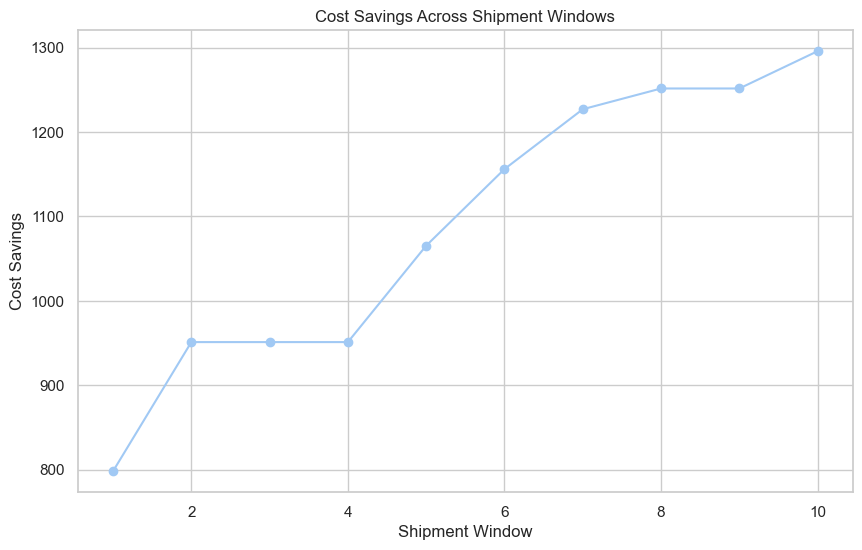

Error processing follow-up question: argument of type 'NoneType' is not iterable
Try reshaping your question.



Choose shipment window or press Enter to use default: 10


,Date,Orders,Total Pallets,Capacity,Utilization %,Order Count,Pallets,PROD TYPE,GROUP,Shipment Cost,Baseline Cost,SHORT_POSTCODE,Load Type
0,2024-01-02,"[82579108, 82595330, 82595334, 82595322, 82617...",36,36,100.0,5,"[17, 3, 3, 2, 11]",AMBCONTROL,ALLOGA UK,427.8,616.5,NG,Full
1,2024-01-02,"[82614233, 82614232]",36,36,100.0,2,"[18, 18]",AMBCONTROL,ALLOGA UK,427.8,567.0,NG,Full
2,2024-01-02,"[82614234, 82595311, 82595318]",35,36,97.2,3,"[18, 15, 2]",AMBCONTROL,ALLOGA UK,427.8,568.7,NG,Full
3,2024-01-10,"[82595325, 82615621, 82624372, 82595324, 82595...",36,36,100.0,5,"[2, 19, 12, 2, 1]",AMBCONTROL,ALLOGA UK,427.8,616.8,NG,Full
4,2024-01-15,"[82595319, 82625446]",27,36,75.0,2,"[5, 22]",AMBCONTROL,ALLOGA UK,427.8,418.6,NG,Full
5,2024-01-18,[82624373],18,36,50.0,1,[18],AMBCONTROL,ALLOGA UK,283.5,283.5,NG,Partial
6,2024-01-22,"[82625436, 82624375, 82628876]",36,36,100.0,3,"[19, 12, 5]",AMBCONTROL,ALLOGA UK,427.8,583.7,NG,Full
7,2024-01-31,[82624374],18,36,50.0,1,[18],AMBCONTROL,ALLOGA UK,283.5,283.5,NG,Partial
8,2024-01-02,"[82595320, 82595329, 82579114, 82601105]",34,36,94.4,4,"[5, 2, 20, 7]",AMBCONTROL,ALLOGA UK LTD - AP 3,424.3,565.0,DE,Full
9,2024-01-02,"[82601107, 82595312, 82595333]",36,36,100.0,3,"[18, 15, 3]",AMBCONTROL,ALLOGA UK LTD - AP 3,424.3,577.5,DE,Full


{'messages': [HumanMessage(content='**Summary of the Conversation:**\n\nThe human asked how to optimize shipment costs for the user ALLOGA UK in January. The AI provided parameters for the analysis, including the date range and customer details. The AI then shared the optimum results, highlighting a shipment window of 10 days, with cost savings of 20.7% and a total shipment cost of 4978.9. The human further inquired about the best shipment window to maximize cost savings, requesting supporting plots and values. The AI encountered an error but later provided a comparison of shipment metrics before and after consolidation, showing significant improvements in pallets per day and per shipment.\n\n**Formatted Response to the First Question:**\n\nTo optimize the shipment costs for user ALLOGA UK in January, consider the following parameters and results:\n\n- **Date Range:** January 1, 2024, to January 31, 2024\n- **Group Method:** Customer Level\n- **Selected Customers:** ALLOGA UK, ALLOGA U

In [109]:
current_state = graph.nodes[state['next']].invoke(state) if state['next']!='FINISH' else 'EXIT'
current_state

In [110]:
state['messages']=add_messages(state['messages'],current_state['messages'])
state['next'] = current_state['next']
state

{'messages': [HumanMessage(content='How can I optimize the shipment costs for user ALLOGA UK in January?', additional_kwargs={}, response_metadata={}, id='9324094b-bbcf-42c9-bf16-1450a21e6cca'),
  AIMessage(content='Calling Cost Saving Agent.', additional_kwargs={}, response_metadata={}, id='c17c4db6-d4bb-43c2-a36c-d94c698bf9fc'),
  HumanMessage(content='**Summary of the Conversation:**\n\nThe human asked how to optimize shipment costs for the user ALLOGA UK in January. The AI provided parameters for the analysis, including the date range and customer details. The AI then shared the optimum results, highlighting a shipment window of 10 days, with cost savings of 20.7% and a total shipment cost of 4978.9. The human further inquired about the best shipment window to maximize cost savings, requesting supporting plots and values. The AI encountered an error but later provided a comparison of shipment metrics before and after consolidation, showing significant improvements in pallets per da

In [281]:
current_state = graph.nodes[state['next']].invoke(state) if state['next']!='FINISH' else 'EXIT'
current_state

{'messages': [AIMessage(content='Calling FINISH.', additional_kwargs={}, response_metadata={})],
 'next': 'FINISH'}

In [282]:
state['messages']=add_messages(state['messages'],current_state['messages'])
state['next'] = current_state['next']
state

{'messages': [HumanMessage(content='How can I optimize the shipment costs for user ALLOGA UK in January?', additional_kwargs={}, response_metadata={}, id='fecc79dd-a0dd-403a-8a9c-e096189bf7e5'),
  AIMessage(content='Calling Cost Saving Agent.', additional_kwargs={}, response_metadata={}, id='4e9a016b-4b55-46a0-af8a-4376e3e10997'),
  HumanMessage(content='**Summary of the Conversation:**\n\nThe human inquired about optimizing shipment costs for ALLOGA UK in January. The AI provided parameters for the analysis, including the date range and customer details. The AI then shared the optimum results, highlighting cost savings and shipment efficiency. The human asked about the number of orders shipped in the second week of January, to which the AI responded with the number. The human requested a plot showing weekly shipments in January, and the AI provided the data and mentioned a bar plot. Finally, the AI shared a comparison of shipment metrics before and after consolidation.\n\n**Formatted 

In [283]:
current_state = graph.nodes[state['next']].invoke(state) if state['next']!='FINISH' else 'EXIT'
current_state

'EXIT'

-----
## Example 1: Finishing when answer is completed

In [67]:
question = "What's the average distance of shipment for top 5 largest customers?"
state = {"messages":[HumanMessage(content=question)],"next":"supervisor"}

================================ Human Message =================================

What's the average distance of shipment for top 5 largest customers?
================================== Ai Message ==================================

Calling BI Agent.


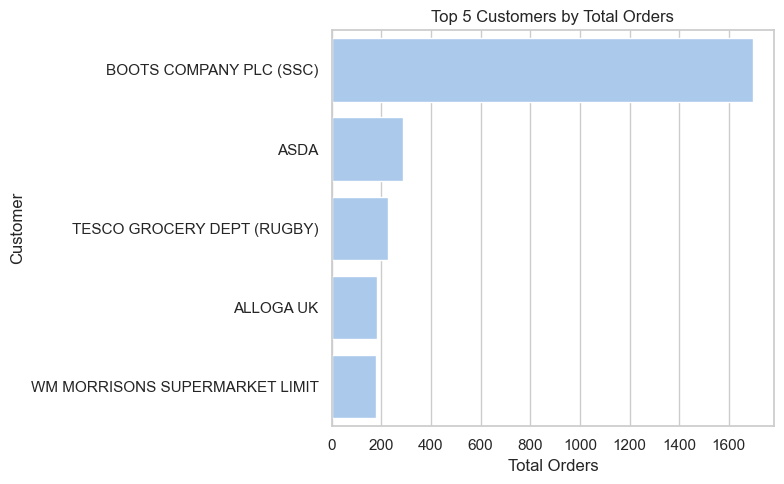

================================ Human Message =================================

To answer this question, I will need to:
1. Group the data by 'Customer' and calculate the total 'Total_Orders' for each customer.
2. Identify the top 5 customers with the largest total orders.
3. Calculate the average 'Distance' of shipments for these top 5 customers.
Solution we got from this approach is:
The average distance of shipment for the top 5 largest customers is 66.5 miles.
================================== Ai Message ==================================

Calling FINISH.


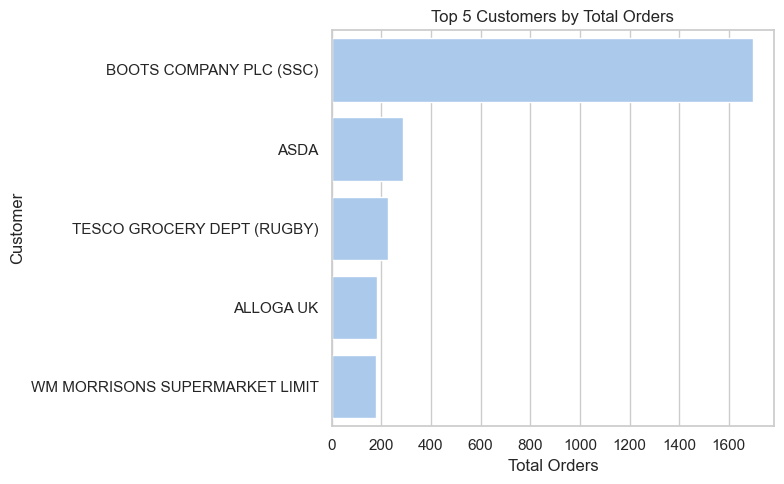

In [68]:
state['messages'][0].pretty_print()
counter=0
while state['next']!='FINISH' and counter<100:
    
    #Getting the current state
    current_state= graph.nodes[state['next']].invoke(state)
    current_state['messages'][0].pretty_print()

    # Updating the state
    state['messages']=add_messages(state['messages'],current_state['messages'])
    state['next'] = current_state['next']
    counter+=1


-----
## Example 2: Routing to different Agent

In [74]:
question = "Identify the customer for which shipment cost is highest and then help me to save the shipment cost for it."

In [75]:
# question = "How can I optimise my spends for top 5 postal codes in terms of spend"

In [76]:
config= {"configurable":{"thread_id":"3"}}

In [77]:
state = {"messages":[HumanMessage(content=question)],"next":"supervisor"}

================================ Human Message =================================

Identify the customer for which shipment cost is highest and then help me to save the shipment cost for it.
================================== Ai Message ==================================

Calling BI Agent.


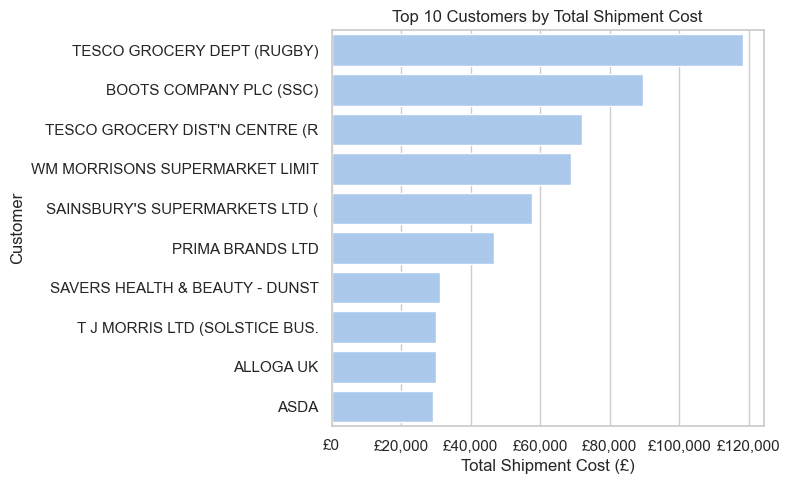

================================ Human Message =================================

To answer this question, I will need to:
1. Group the data by 'Customer' and sum the 'Cost' for each customer to find the total shipment cost per customer.
2. Identify the customer with the highest total shipment cost.
3. Analyze the shipment data for this customer to identify potential cost-saving opportunities, such as reducing the number of shipments or optimizing the distance.
Solution we got from this approach is:
The customer with the highest shipment cost is TESCO GROCERY DEPT (RUGBY) with a total cost of £118385.5. To save on shipment costs, consider optimizing the number of shipments (currently 229 orders and 5195 pallets) and reducing the average distance (currently 107.4 km) or cost per order (currently £517.0).
================================== Ai Message ==================================

Calling Cost Saving Agent.
```json
{
    "start_date": "2023-01-01",
    "end_date": "2024-11-30",
    

,Shipment Window,Total Orders,Total Shipments,Total Shipment Cost,Total Baseline Cost,Cost Savings,Percent Savings,Average Utilization,CO2 Emission
0,1,678,94,28757.2,41726.8,12969.6,31.1,65.1,33335.1
1,2,678,82,27825.9,41726.8,13900.9,33.3,74.6,34002.0
2,3,678,74,26969.1,41726.8,14757.7,35.4,82.7,34539.1
3,4,678,71,26877.0,41726.8,14849.8,35.6,86.2,34765.3
4,5,678,67,26475.2,41726.8,15251.6,36.6,91.3,34846.4
5,6,678,64,26053.9,41726.8,15672.9,37.6,95.6,35062.4
6,7,678,64,25923.4,41726.8,15803.4,37.9,95.6,35078.8
7,8,678,62,25724.5,41726.8,16002.3,38.4,98.7,35212.1
8,9,678,62,25828.3,41726.8,15898.5,38.1,98.7,35234.7
9,10,678,63,25718.7,41726.8,16008.1,38.4,97.1,35202.1


 
Choose shipment window or press Enter to use default:  


,Date,Orders,Total Pallets,Capacity,Utilization %,Order Count,Pallets,PROD TYPE,GROUP,Shipment Cost,Baseline Cost,SHORT_POSTCODE,Load Type
0,2024-01-02,"[82579108, 82595330, 82595334, 82595322, 82620...",36,36,100.0,8,"[17, 3, 3, 2, 4, 3, 3, 1]",AMBCONTROL,NG,427.8,666.0,NG,Full
1,2024-01-02,[82619300],51,36,141.7,1,[51],AMBCONTROL,NG,427.9,427.9,NG,Full
2,2024-01-02,[82619303],37,36,102.8,1,[37],AMBCONTROL,NG,427.8,427.8,NG,Full
3,2024-01-02,"[82614233, 82614232]",36,36,100.0,2,"[18, 18]",AMBCONTROL,NG,427.8,567.0,NG,Full
4,2024-01-02,"[82614234, 82616327, 82617681]",36,36,100.0,3,"[18, 16, 2]",AMBCONTROL,NG,427.8,583.5,NG,Full
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2024-02-28,"[82665201, 82665298, 82665862, 82660777, 82673...",36,36,100.0,7,"[1, 1, 1, 26, 4, 2, 1]",AMBIENT,NG,389.5,519.6,NG,Full
58,2024-03-01,"[82667774, 82667780, 82669886, 82669889, 82669...",27,36,75.0,24,"[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, ...",AMBIENT,NG,389.5,751.8,NG,Full
59,2024-03-11,"[82673484, 82678845, 82680265, 82677537, 82683...",36,36,100.0,19,"[11, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",AMBIENT,NG,389.5,785.2,NG,Full
60,2024-03-11,"[0082673063A, 82680268, 82682953, 82685100, 82...",36,36,100.0,11,"[26, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",AMBIENT,NG,389.5,586.5,NG,Full


================================ Human Message =================================

**Summary of the Conversation:**

The conversation involves an analysis of shipment data to identify cost-saving opportunities. The human outlines a plan to group data by customer, sum the shipment costs, and identify the customer with the highest costs. The analysis reveals that TESCO GROCERY DEPT (RUGBY) has the highest shipment cost of £118,385.5. Suggestions for cost savings include optimizing the number of shipments and reducing the average distance or cost per order. The AI provides parameters for a specific analysis period and location, along with optimum results showing significant cost savings and improved utilization. A comparison of shipment data before and after consolidation shows a substantial reduction in the number of days and an increase in pallets per day and per shipment.

**Formatted Response to the First Question:**

To answer this question, I will need to:

1. Group the data by 'Cust

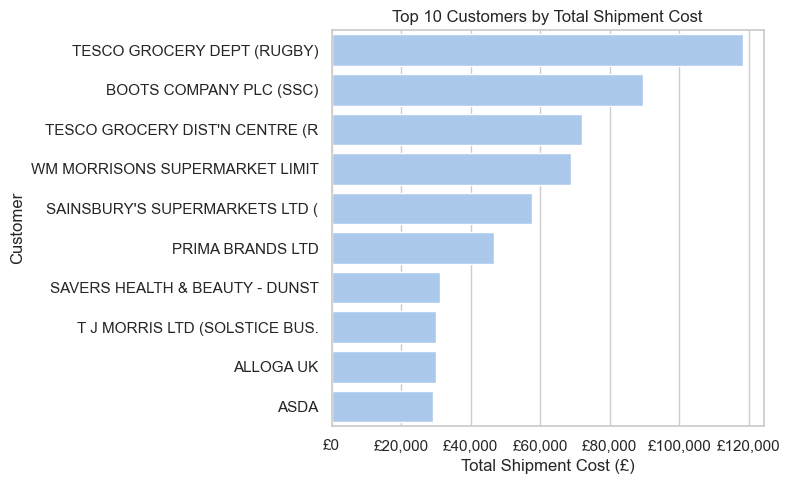

In [78]:
state['messages'][0].pretty_print()
counter=0
while state['next']!='FINISH' and counter<100:
    #Getting the current state
    current_state= graph.nodes[state['next']].invoke(state,config)
    current_state['messages'][0].pretty_print()
#     chat_msg.append(current_state['messages'][0])
    

    # Updating the state
    state['messages']=add_messages(state['messages'],current_state['messages'])
    state['next'] = current_state['next']
    counter+=1
#     state

-----
## Example 3: Interrupting the workflow and taking input from user

In [174]:
# counter=0
# while True:
#     question = input("Ask your question or Press Enter to Exit:\n")
#     if not question:
#         break
#     else:
        
#         state = {"messages":[HumanMessage(content=question)],"next":"supervisor"}
#         while state['next']!='FINISH' and counter<100:

#             #Getting the current state
#             current_state= graph.nodes[state['next']].invoke(state)
#             current_state['messages'][0].pretty_print()

#             # Updating the state
#             state['messages']=add_messages(state['messages'],current_state['messages'])
#             state['next'] = current_state['next']
#             counter+=1


----The End---

-----